In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import math
import torchtt as tntt
import os
from tutils import *
from cascade import *

# Rank growth

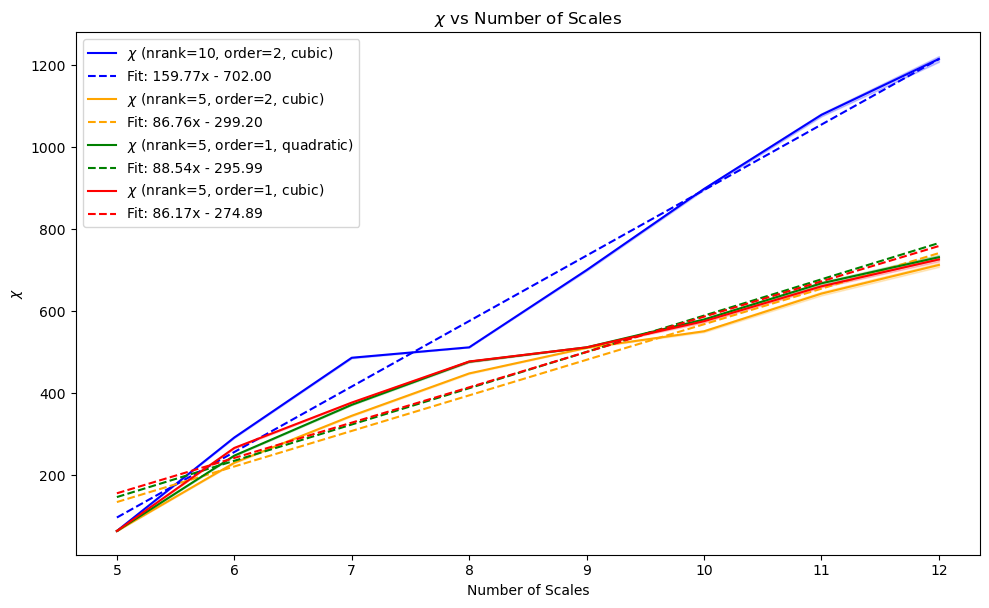

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import linregress

# --- Load datasets ---
df_10_c = pd.read_csv("./data/ranks10c_1em8_p.csv")
df_10_c['noise_rank'] = 10
df_10_c['order'] = 2
df_10_c['method'] = 'cubic'   # mark method

df_5_c = pd.read_csv("./data/ranks5c_1em8_p.csv")
df_5_c['noise_rank'] = 5
df_5_c['order'] = 2
df_5_c['method'] = 'cubic'    # mark method

df_5_c1 = pd.read_csv("./data/ranks5c1_1em8_p.csv")
df_5_c1['noise_rank'] = 5
df_5_c1['order'] = 1
df_5_c1['method'] = 'cubic'   # mark method

df_5_q = pd.read_csv("./data/ranks5q_1em8_p.csv")
df_5_q['noise_rank'] = 5
df_5_q['order'] = 1
df_5_q['method'] = 'quadratic'   # mark method

# --- Merge datasets ---
merged_df = pd.concat([df_10_c, df_5_c, df_5_q, df_5_c1], ignore_index=True)

# --- Grouped stats ---
grouped = merged_df.groupby(['Dimension', 'noise_rank', 'order', 'method']).agg(
    maxrank_mean=('MaxRank', 'mean'),
    maxrank_std=('MaxRank', 'std')
).reset_index()

# --- Setup plot ---
phi = (1 + math.sqrt(5)) / 2  # Golden ratio
fig, ax = plt.subplots(figsize=(10, 10/phi))

# --- Define styles ---
styles = {
    (10, 2, 'cubic'): {'color': 'blue'},
    (5, 2, 'cubic'): {'color': 'orange'},
    (5, 1, 'quadratic'): {'color': 'green'},
    (5, 1, 'cubic'): {'color': 'red'}
}

# --- Plotting ---
for (rank, order, method), style in styles.items():
    group = grouped[
        (grouped['noise_rank'] == rank) &
        (grouped['order'] == order) &
        (grouped['method'] == method)
    ]

    if group.empty:
        continue

    x = group['Dimension'].values
    maxrank = group['maxrank_mean'].values
    maxrank_err = group['maxrank_std'].values

    label = f"$\chi$ (nrank={rank}, order={order}, {method})"
    ax.plot(x, maxrank, linestyle='-', label=label, color=style['color'])
    ax.fill_between(x, maxrank - maxrank_err, maxrank + maxrank_err, color=style['color'], alpha=0.2)

    # Linear fit
    raw = merged_df[
        (merged_df['noise_rank'] == rank) &
        (merged_df['order'] == order) &
        (merged_df['method'] == method)
    ]

    if len(raw) > 1:
        slope, intercept, *_ = linregress(raw['Dimension'], raw['MaxRank'])
        sign = '+' if intercept >= 0 else '-'
        ax.plot(x, intercept + slope * x, linestyle='--', linewidth=1.5,
                color=style['color'],
                label=f"Fit: {slope:.2f}x {sign} {abs(intercept):.2f}")

# --- Final formatting ---
ax.set_title(r'$\chi$ vs Number of Scales')
ax.set_xlabel('Number of Scales')
ax.set_ylabel(r'$\chi$')
ax.legend()
plt.tight_layout()
plt.savefig("chi_vs_cores_maxrank.pdf", format='pdf', bbox_inches='tight')
plt.show()


# Cascade metrics

-5.342725437056754


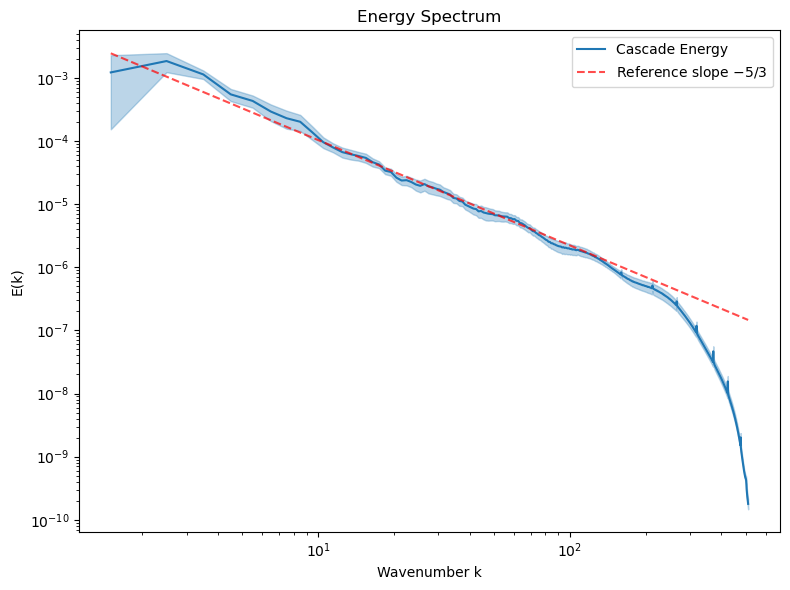

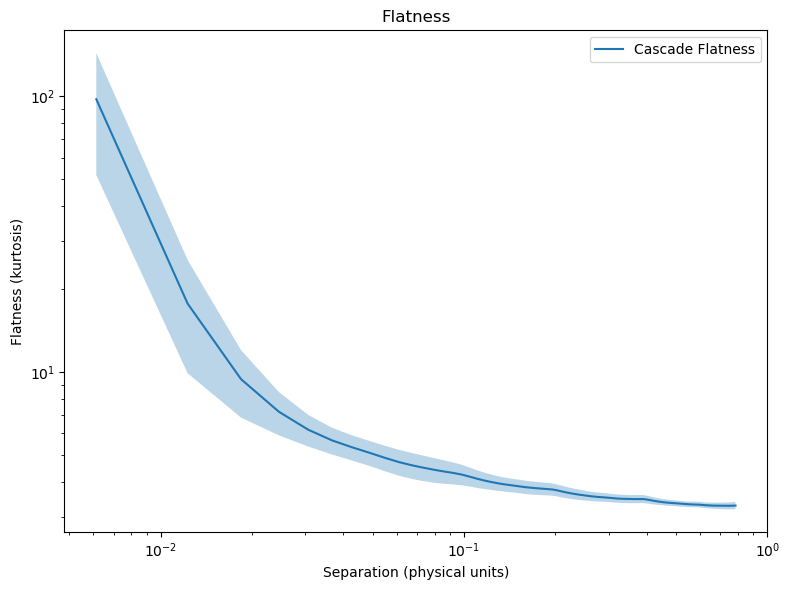

'\n# 2) Scaling exponent of the energy spectrum\nscaling = np.log(E_mean) / np.log(k)\n# Error propagation: σ_S = σ_E / (E_mean * |ln(k)|)\nsigma_scaling = E_std / (E_mean * np.abs(np.log(k)))\n# Plot scaling exponent with error shading\nplt.figure(figsize=(8, 6))\nplt.plot(k, scaling, label=\'Scaling exponent\')\nplt.fill_between(k, scaling - sigma_scaling, scaling + sigma_scaling, alpha=0.3, label=\'±1σ error\')\nplt.title("Scaling Exponent of Energy Spectrum")\nplt.show()\n'

In [4]:
# Load previously saved data
df_energy    = pd.read_csv('./data/energy_spectraR0.csv')
df_flatness  = pd.read_csv('./data/flatnessR0.csv')

# Drop rows where separation is NaN
# df_flatness = df_flatness.dropna(subset=['separation'])

# 1) Energy statistics: mean and std over runs at each k_center
energy_stats = df_energy.groupby('k_center')['E_k'].agg(['mean', 'std']).reset_index()
k      = energy_stats['k_center'].values
E_mean = energy_stats['mean'].values
E_std  = energy_stats['std'].values

# --- Linear fit on the window where 2 <= k <= 300 ---
# mask = (k >= 2) & (k <= 300)
# log_k_fit = np.log(k[mask])
# log_E_fit = np.log(E_mean[mask])
# slope, intercept, *_ = linregress(log_k_fit, log_E_fit)
# fit_line = np.exp(intercept + slope * np.log(k))  # for full overlay

# --- Reference line with slope -5/3 ---
k_ref = np.linspace(k.min(), k.max(), 200)
ref_slope = -5/3
# Choose reference level so that it matches roughly the curve height
ref_intercept = np.log(E_mean[ (k > 10) & (k < 400) ][0]) - ref_slope * np.log(k[(k > 10) & (k < 400)][0])
print(ref_intercept)
ref_line = np.exp(ref_intercept) * k_ref**(ref_slope)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.loglog(k, E_mean, label='Cascade Energy', color='tab:blue')
plt.fill_between(k, E_mean - E_std, E_mean + E_std, alpha=0.3, color='tab:blue')
# plt.loglog(k, fit_line, '--', color='red', alpha=0.5, label=f"Fit: slope = {slope:.2f}")
plt.loglog(k_ref, ref_line, '--', color='red', alpha=0.7, label=r"Reference slope $-5/3$")

plt.xlabel("Wavenumber k")
plt.ylabel("E(k)")
plt.title("Energy Spectrum")
plt.legend()
plt.tight_layout()
plt.savefig("./plots/energy.pdf", format='pdf')
plt.show()

# 3) Flatness statistics: mean and std over runs at each separation
flat_stats = df_flatness.groupby('separation')['flatness'].agg(['mean', 'std']).reset_index()
s       = flat_stats['separation'].values
F_mean  = flat_stats['mean'].values
F_std   = flat_stats['std'].values

# Plot flatness vs separation in log-log space
plt.figure(figsize=(8, 6))
plt.loglog(s, F_mean, label='Cascade Flatness')
plt.fill_between(s, F_mean - F_std, F_mean + F_std, alpha=0.3)
plt.xlabel("Separation (physical units)")
plt.ylabel("Flatness (kurtosis)")
plt.title("Flatness")
plt.legend()
plt.tight_layout()
plt.savefig("./plots/flatness.pdf", format='pdf')
plt.show()

"""
# 2) Scaling exponent of the energy spectrum
scaling = np.log(E_mean) / np.log(k)
# Error propagation: σ_S = σ_E / (E_mean * |ln(k)|)
sigma_scaling = E_std / (E_mean * np.abs(np.log(k)))
# Plot scaling exponent with error shading
plt.figure(figsize=(8, 6))
plt.plot(k, scaling, label='Scaling exponent')
plt.fill_between(k, scaling - sigma_scaling, scaling + sigma_scaling, alpha=0.3, label='±1σ error')
plt.title("Scaling Exponent of Energy Spectrum")
plt.show()
"""


# Snapshots

/home/users/siddhartha.morales/miniconda3/envs/tnttenv/lib/python3.11/site-packages/torchtt/_extras.py:862: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dct = tn.load(path)

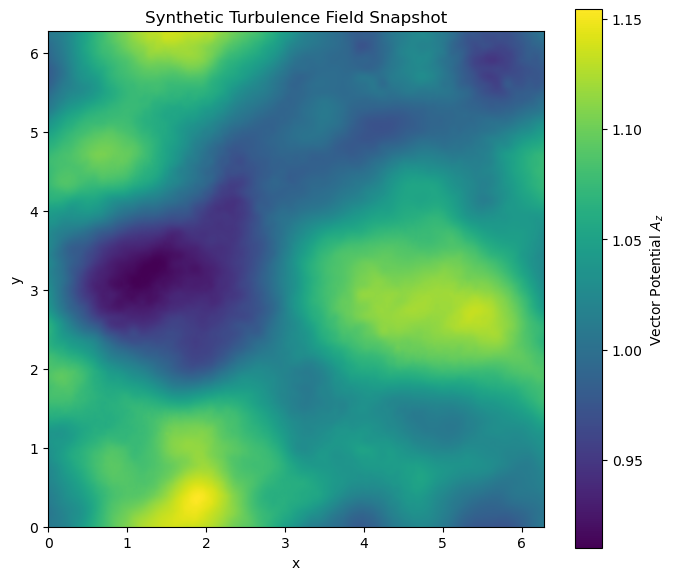

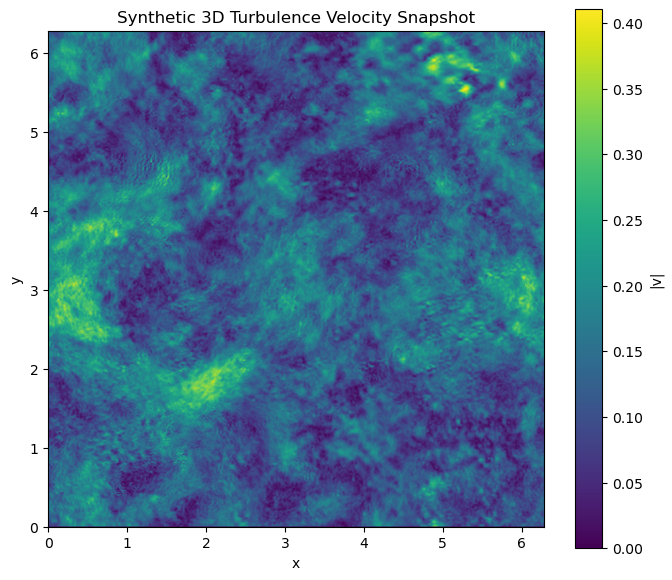

In [10]:
nscales  = 10
N        = 2**nscales
L        = 2 * np.pi
folder = "./data/mps/10_0"
j = 3

Ax = tntt.load(os.path.join(folder, f"Ax_run{j}.TT"))
Ay = tntt.load(os.path.join(folder, f"Ay_run{j}.TT"))
Az = tntt.load(os.path.join(folder, f"Az_run{j}.TT"))
A_x = np.zeros([2**nscales]*3, dtype=np.float64)
A_y = np.zeros([2**nscales]*3, dtype=np.float64)
A_z = np.zeros([2**nscales]*3, dtype=np.float64)
A_x = z_order_to_normal_nopara(Ax.full().cpu().numpy().ravel() , A_x, 2**nscales,2**nscales,2**nscales)
A_y = z_order_to_normal_nopara(Ay.full().cpu().numpy().ravel() ,A_y, 2**nscales,2**nscales,2**nscales)
A_z = z_order_to_normal_nopara(Az.full().cpu().numpy().ravel() ,A_z, 2**nscales,2**nscales,2**nscales)

u, v, w = compute_velocity_from_vector_potential(A_x, A_y, A_z, L)
speed = np.sqrt(u**2 + v**2 + w**2)


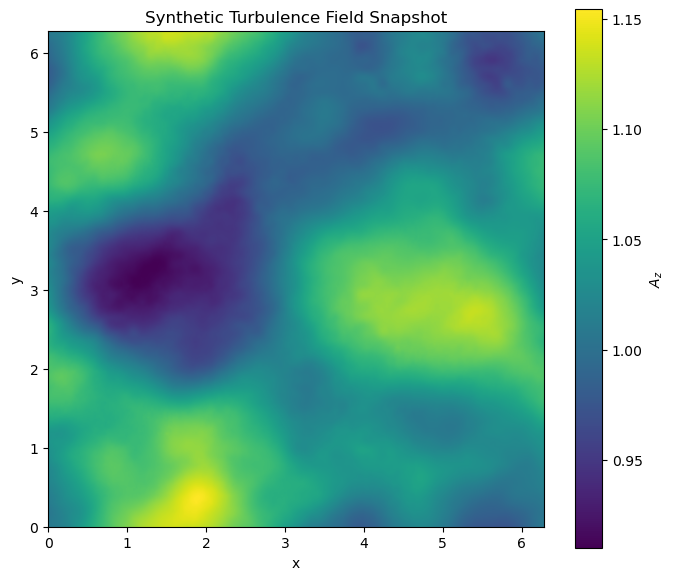

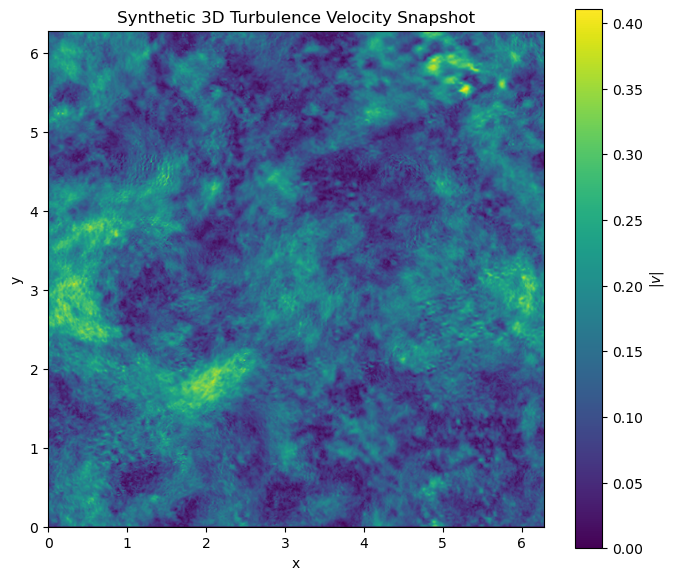

In [12]:
# Plot one mid-plane slice (here A_z) of the vector potential
plt.figure(figsize=(8, 7))
plt.imshow(
    A_z[:, :, N//2],
    origin="lower",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
    cmap="viridis",
)
plt.colorbar(label=f"$A_z$")
plt.title(
    "Synthetic Turbulence Field Snapshot"
)
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("./plots/Az_mid.pdf", format='pdf')
plt.show()

# Plot velocity magnitude for cascade-generated field (mid-plane slice)
plt.figure(figsize=(8, 7))
plt.imshow(speed[:, :, N//2], origin="lower", extent=[0, 2 * np.pi, 0, 2 * np.pi], cmap="viridis")
plt.colorbar(label=f"$|v|$")
plt.title(
    "Synthetic 3D Turbulence Velocity Snapshot"
)
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("./plots/v_mid.pdf", format='pdf')
plt.show()